<a href="https://colab.research.google.com/github/PatilVaishnav131/disease-prediction-ai/blob/main/skin_disease_classification_using_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-08-10 10:44:17.753279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754822657.949500      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754822658.008389      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
import pandas as pd

# Path to the dataset
parent_folder_path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

# Lists to store image paths and labels
image_paths = []
class_labels = []

# Dictionary to map integer class labels to class names
class_label_map = {}

# Loop through each subfolder (each disease class)
for subfolder_name in os.listdir(parent_folder_path):
    # e.g. '1.Melanoma', '2.Atopic', ...
    parts = subfolder_name.split(".")
    class_label = int(parts[0]) - 1  # ensure class_label starts at 0
    # Extract class name from folder (handles potential whitespace)
    class_name = parts[1].strip()
    class_label_map[class_label] = class_name

    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    for image_name in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_name)
        image_paths.append(image_path)
        class_labels.append(class_label)

# Create DataFrame from paths and labels
df = pd.DataFrame({
    "image_path": image_paths,
    "class_label": class_labels
})

# Number of distinct classes, computed directly from labels
num_classes = df["class_label"].nunique()

print("Number of classes:", num_classes)
print("Class label map:", class_label_map)
print(df.head())


Number of classes: 10
Class label map: {0: 'Eczema 1677', 9: 'Warts Molluscum and other Viral Infections - 2103', 3: 'Basal Cell Carcinoma (BCC) 3323', 6: 'Psoriasis pictures Lichen Planus and related diseases - 2k', 4: 'Melanocytic Nevi (NV) - 7970', 8: 'Tinea Ringworm Candidiasis and other Fungal Infections - 1', 2: 'Atopic Dermatitis - 1', 5: 'Benign Keratosis-like Lesions (BKL) 2624', 7: 'Seborrheic Keratoses and other Benign Tumors - 1', 1: 'Melanoma 15'}
                                          image_path  class_label
0  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
1  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
2  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
3  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
4  /kaggle/input/skin-diseases-image-dataset/IMG_...            0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd

# Assuming you already have:
# image_paths → list of file paths
# class_labels → list of class names or integers

# 1️⃣ Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': class_labels
})

# 2️⃣ Split into train+val and test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,            # 10% for test
    stratify=df['label'],     # preserve class distribution
    random_state=42
)

# 3️⃣ Split train+val into train and validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,            # 20% of train+val for validation
    stratify=train_val_df['label'],
    random_state=42
)

print("Before balancing (train):\n", train_df['label'].value_counts())
print("Validation set distribution:\n", val_df['label'].value_counts())
print("Test set distribution:\n", test_df['label'].value_counts())

# 4️⃣ Oversample ONLY the training set
max_count = train_df['label'].value_counts().max()
balanced_train_parts = []

for class_name, group in train_df.groupby('label'):
    if len(group) < max_count:
        group_upsampled = resample(
            group,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        balanced_train_parts.append(group_upsampled)
    else:
        balanced_train_parts.append(group)

train_df_balanced = pd.concat(balanced_train_parts).reset_index(drop=True)

print("\nAfter balancing (train):\n", train_df_balanced['label'].value_counts())

# 5️⃣ Convert back to lists for ImageDataGenerator
train_image_paths = train_df_balanced['image_path'].tolist()
train_labels = train_df_balanced['label'].astype(str).tolist()

val_image_paths = val_df['image_path'].tolist()
val_labels = val_df['label'].astype(str).tolist()

test_image_paths = test_df['image_path'].tolist()
test_labels = test_df['label'].astype(str).tolist()


Before balancing (train):
 label
4    5738
3    2393
1    2261
9    1514
5    1497
6    1479
7    1329
8    1226
0    1207
2     905
Name: count, dtype: int64
Validation set distribution:
 label
4    1435
3     598
1     565
9     379
5     374
6     370
7     333
8     306
0     302
2     226
Name: count, dtype: int64
Test set distribution:
 label
4    797
3    332
1    314
9    210
5    208
6    206
7    185
8    170
0    168
2    126
Name: count, dtype: int64

After balancing (train):
 label
0    5738
1    5738
2    5738
3    5738
4    5738
5    5738
6    5738
7    5738
8    5738
9    5738
Name: count, dtype: int64


In [ ]:
 from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert labels to strings for categorical mode
train_df_balanced['label'] = train_df_balanced['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Just rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),  # Change to match your model input
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Test generator (no shuffling)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 57380 validated image filenames belonging to 10 classes.
Found 4888 validated image filenames belonging to 10 classes.
Found 2716 validated image filenames belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

num_classes = 10  # change if needed

# --- Base model ---
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Step 1: Freeze base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    'best_densenet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Step 1 training (frozen base)
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Step 2: Unfreeze top layers of DenseNet
for layer in base_model.layers[-100:]:  # unfreeze last ~100 layers
    layer.trainable = True

model.compile(optimizer=Adam(1e-4),  # lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 2 training (fine-tuning)
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


I0000 00:00:1754822711.226877      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


I0000 00:00:1754822735.646766      95 service.cc:148] XLA service 0x7b6c50003a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754822735.647488      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754822738.395757      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1794 ━━━━━━━━━━━━━━━━━━━━ 1:34 53ms/step - accuracy: 0.1094 - loss: 3.2803   

I0000 00:00:1754822749.090498      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1794/1794 ━━━━━━━━━━━━━━━━━━━━ 995s 537ms/step - accuracy: 0.3675 - loss: 1.7229 - val_accuracy: 0.6289 - val_loss: 1.0101 - learning_rate: 0.0010
Epoch 2/2
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 836s 466ms/step - accuracy: 0.4853 - loss: 1.3406 - val_accuracy: 0.6240 - val_loss: 1.0152 - learning_rate: 0.0010
Epoch 1/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 936s 489ms/step - accuracy: 0.5232 - loss: 1.3203 - val_accuracy: 0.7252 - val_loss: 0.7485 - learning_rate: 1.0000e-04
Epoch 2/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 851s 474ms/step - accuracy: 0.6800 - loss: 0.8608 - val_accuracy: 0.7326 - val_loss: 0.7581 - learning_rate: 1.0000e-04
Epoch 3/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 850s 474ms/step - accuracy: 0.7665 - loss: 0.6364 - val_accuracy: 0.7662 - val_loss: 0.7164 - learning_rate: 1.0000e-04
Epoch 4/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 850s 474ms/step - accuracy: 0.8213 - loss: 0.4949 - val_accuracy: 0.7600 - val_loss: 0.8079 - learning_rate: 1.0000e-04
Epoch 5/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 843s 4

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("best_densenet_model.keras")

# Predict on test set
pred_probs = model.predict(test_generator, verbose=1)

# Convert probabilities to class predictions
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("✅ Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(true_classes, pred_classes):.4f}")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Save predictions to CSV
results_df = pd.DataFrame({
    "filename": test_generator.filenames,
    "true_label": [class_labels[i] for i in true_classes],
    "predicted_label": [class_labels[i] for i in pred_classes]
})
results_df.to_csv("test_predictions.csv", index=False)

print("📄 Predictions saved to test_predictions.csv")


85/85 ━━━━━━━━━━━━━━━━━━━━ 59s 562ms/step
✅ Test Set Evaluation:
Accuracy: 0.8071
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       168
           1       0.91      0.96      0.93       314
           2       0.66      0.61      0.64       126
           3       0.90      0.89      0.89       332
           4       0.96      0.90      0.93       797
           5       0.69      0.79      0.74       208
           6       0.69      0.51      0.58       206
           7       0.78      0.71      0.74       185
           8       0.67      0.66      0.66       170
           9       0.66      0.78      0.71       210

    accuracy                           0.81      2716
   macro avg       0.75      0.75      0.75      2716
weighted avg       0.81      0.81      0.81      2716

📄 Predictions saved to test_predictions.csv


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# y_test = True labels
# y_pred = Model predictions

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


NameError: name 'y_test' is not defined

📊 Evaluating on Validation Set...
153/153 ━━━━━━━━━━━━━━━━━━━━ 56s 260ms/step - accuracy: 0.7907 - loss: 0.8232
Validation Accuracy: 0.7913, Validation Loss: 0.8291

📊 Evaluating on Test Set...
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.8011 - loss: 0.8012
Test Accuracy: 0.8071, Test Loss: 0.7729
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step

📈 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       168
           1       0.91      0.96      0.93       314
           2       0.66      0.61      0.64       126
           3       0.90      0.89      0.89       332
           4       0.96      0.90      0.93       797
           5       0.69      0.79      0.74       208
           6       0.69      0.51      0.58       206
           7       0.78      0.71      0.74       185
           8       0.67      0.66      0.66       170
           9       0.66      0.78      0.71       210

    accuracy             

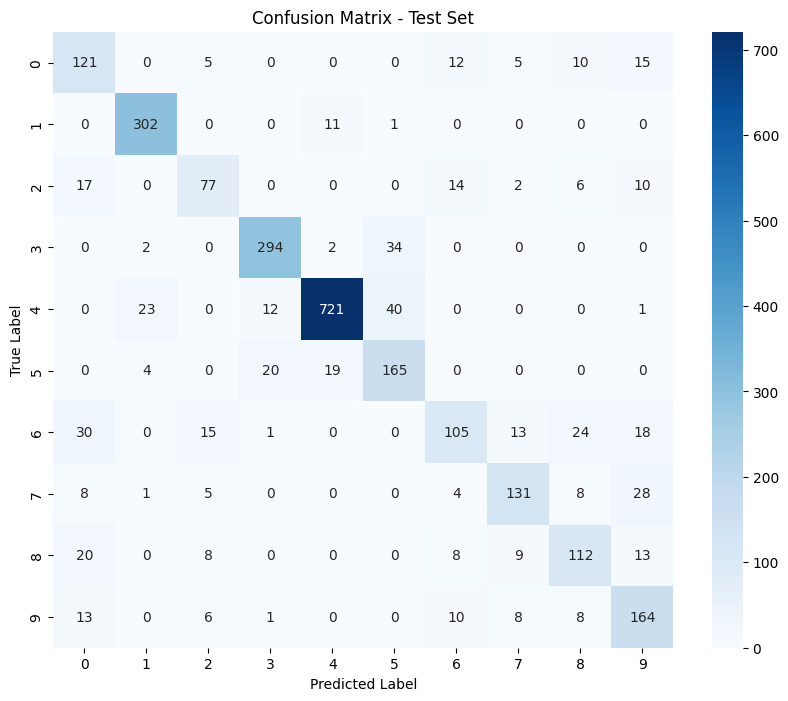

✅ Evaluation results saved to test_evaluation_results.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model

# Load trained DenseNet model
model = load_model("best_densenet_model.keras")

# ----- Evaluate on Validation Set -----
print("📊 Evaluating on Validation Set...")
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

# ----- Evaluate on Test Set -----
print("\n📊 Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# ----- Predictions -----
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# ----- Classification Report -----
print("\n📈 Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# ----- Confusion Matrix -----
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# ----- Save Predictions -----
results_df = pd.DataFrame({
    "filename": test_generator.filenames,
    "true_label": [class_labels[i] for i in true_classes],
    "predicted_label": [class_labels[i] for i in pred_classes],
    "confidence": np.max(pred_probs, axis=1)
})
results_df.to_csv("test_evaluation_results.csv", index=False)
print("✅ Evaluation results saved to test_evaluation_results.csv")


📊 Evaluating on Validation Set...
153/153 ━━━━━━━━━━━━━━━━━━━━ 57s 261ms/step - accuracy: 0.7907 - loss: 0.8232
Validation Accuracy: 0.7913, Validation Loss: 0.8291

📊 Evaluating on Test Set...
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.8011 - loss: 0.8012
Test Accuracy: 0.8071, Test Loss: 0.7729
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 309ms/step

📈 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       168
           1       0.91      0.96      0.93       314
           2       0.66      0.61      0.64       126
           3       0.90      0.89      0.89       332
           4       0.96      0.90      0.93       797
           5       0.69      0.79      0.74       208
           6       0.69      0.51      0.58       206
           7       0.78      0.71      0.74       185
           8       0.67      0.66      0.66       170
           9       0.66      0.78      0.71       210

    accuracy             

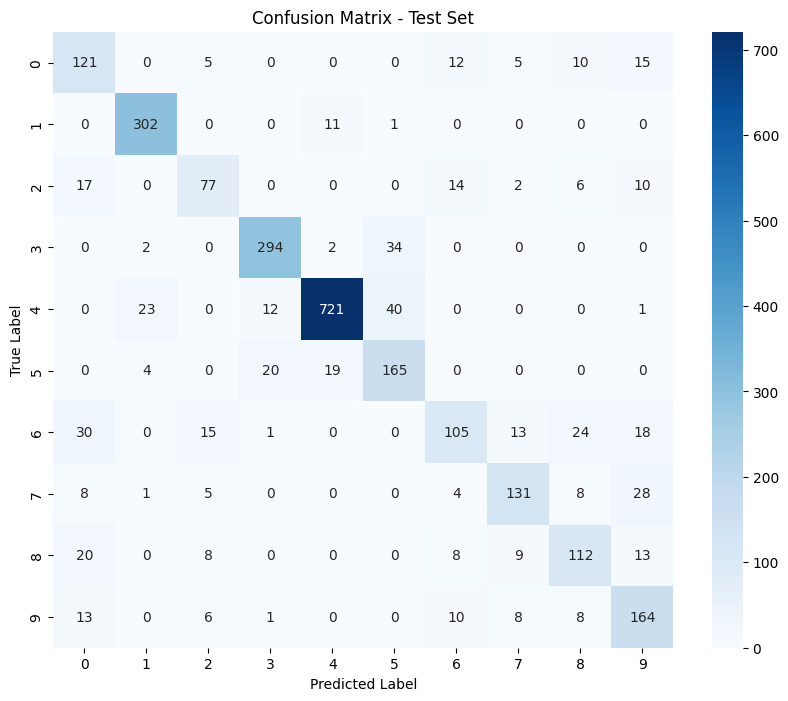

✅ Evaluation results saved to test_evaluation_results.csv


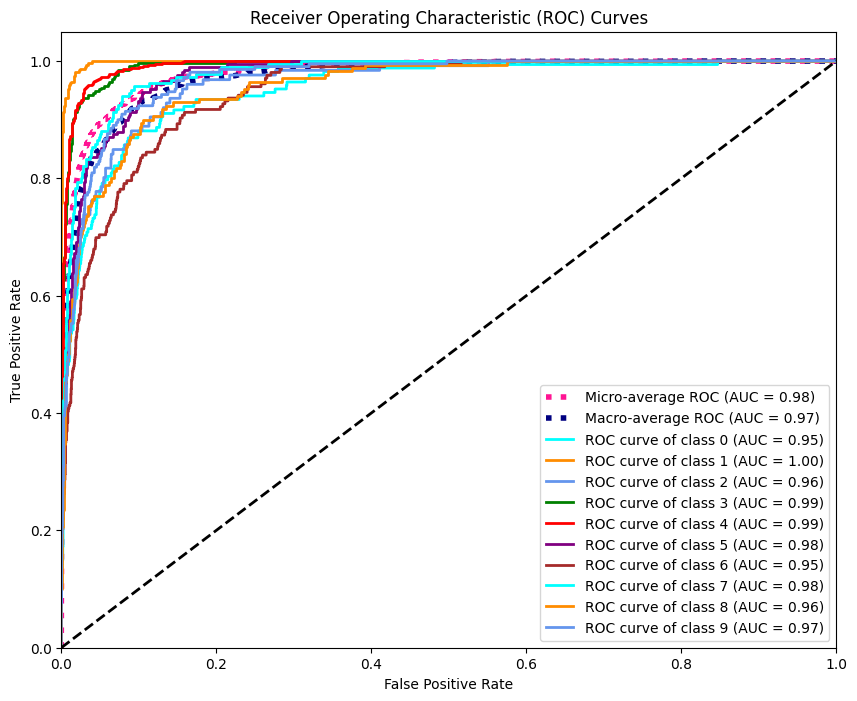

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model
from itertools import cycle

# Load trained model
model = load_model("best_densenet_model.keras")

# ----- Evaluate on Validation Set -----
print("📊 Evaluating on Validation Set...")
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

# ----- Evaluate on Test Set -----
print("\n📊 Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# ----- Predictions -----
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# ----- Classification Report -----
print("\n📈 Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# ----- Confusion Matrix -----
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# ----- Save Predictions -----
results_df = pd.DataFrame({
    "filename": test_generator.filenames,
    "true_label": [class_labels[i] for i in true_classes],
    "predicted_label": [class_labels[i] for i in pred_classes],
    "confidence": np.max(pred_probs, axis=1)
})
results_df.to_csv("test_evaluation_results.csv", index=False)
print("✅ Evaluation results saved to test_evaluation_results.csv")

# ----- ROC Curves -----
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
true_classes_bin = label_binarize(true_classes, classes=range(len(class_labels)))
n_classes = true_classes_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(true_classes_bin.ravel(), pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
